In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import muon
import ott
import functools
import logging
import typing as t

import anndata as ad
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import scanpy as sc
import scipy.sparse as sp
import scipy.stats as ss
from ott.geometry import costs, geometry, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from sklearn import metrics, model_selection
from ott.geometry import costs as sparse_costs

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['default', 'despine']


In [3]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [5]:
mudata = mudata[mudata.obs["cell_type"].isin(endocrine_celltypes)]

In [6]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1).astype("category")

/tmp/ipykernel_1105607/2312537565.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1).astype("category")


In [7]:
adata=mudata["rna"]


In [8]:
adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"]
adata.obsm["X_umap"] = mudata.obsm["X_umap"]
adata.obs["time"] = mudata.obs["time"] 

In [9]:
adata.X = adata.layers["raw_counts"]

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(adata, inplace=True, subset=True)

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [12]:
gex_early = adata[adata.obs["time"]==15.5].X.A
gex_late = adata[adata.obs["time"]==16.5].X.A

In [13]:
x=gex_early
y=gex_late

In [14]:
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, batch_size=1)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport

In [15]:
map_l1 = entropic_map(x, y, costs.ElasticL1(scaling_reg=10.0))

In [16]:
from tqdm import tqdm
batch_size=100
push_forward = []
for i in tqdm(range(0, len(x), batch_size)):
    push_forward.append(map_l1(x[i:i+batch_size]))

100%|█████████████████████████████████████████████████████████████████████████████████████| 52/52 [1:17:14<00:00, 89.13s/it]


In [17]:
ls_flattened=[]
for el in push_forward:
    ls_flattened.extend(el)

In [18]:
res=np.asarray(ls_flattened)

In [19]:
gene_mask = (np.abs(res-x) > 1e-6)

In [20]:
adata_15 = adata[adata.obs["time"].isin((15.5, ))]

In [21]:
adata_15.layers["sparse_mask"] = gene_mask

/tmp/ipykernel_1105607/1174042063.py:1: ImplicitModificationWarning: Setting element `.layers['sparse_mask']` of view, initializing view as actual.
  adata_15.layers["sparse_mask"] = gene_mask


In [23]:
import os
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/sparse_monge"
adata_15.write(os.path.join(output_dir, "adata_15_with_sparse_mask_automatic_hvg.h5ad"))

In [24]:
adata_15.var["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=0)
adata_15.obs["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=1)

In [25]:
adata_15.var["sparse_counts"].sort_values()[-5:]/len(adata_15)

Mdk         0.236570
Pnliprp1    0.518656
Ctrb1       0.538582
Iapp        0.565931
Ins1        0.725142
Name: sparse_counts, dtype: float64

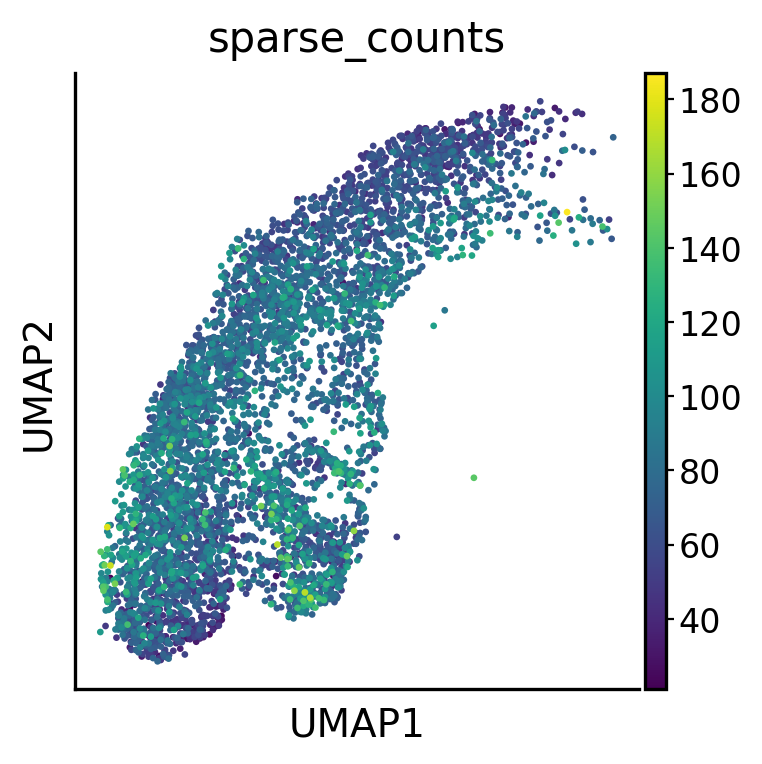

In [26]:
sc.pl.umap(adata_15, color='sparse_counts')

In [27]:
res_dict = {}
res_dict_2 = {}
for cell_type in endocrine_celltypes:
    adata_tmp = adata_15[adata_15.obs["cell_type"]==cell_type]
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    adata_tmp.obs["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=1)
    res_dict[cell_type] = adata_tmp.var["sparse_counts"].sort_values()[-5:]/len(adata_tmp)
    res_dict_2[cell_type] = (adata_tmp.var["sparse_counts"]/len(adata_tmp)).var()

/tmp/ipykernel_1105607/2226181577.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)


In [28]:
res_dict

{'Ngn3 low': Mdk         0.368243
 Ctrb1       0.646959
 Pnliprp1    0.665541
 Iapp        0.800676
 Ins1        0.898649
 Name: sparse_counts, dtype: float64,
 'Ngn3 high': Mdk         0.434468
 Pnliprp1    0.605358
 Ctrb1       0.619117
 Iapp        0.747285
 Ins1        0.851557
 Name: sparse_counts, dtype: float64,
 'Fev+': Ffar2       0.321008
 Pnliprp1    0.542857
 Ctrb1       0.631933
 Iapp        0.786555
 Ins1        0.830252
 Name: sparse_counts, dtype: float64,
 'Fev+ Alpha': Arx         0.446043
 Ctrb1       0.525180
 Pnliprp1    0.661871
 Iapp        0.741007
 Ins1        0.856115
 Name: sparse_counts, dtype: float64,
 'Fev+ Beta': Pdx1        0.206810
 Iapp        0.348045
 Pnliprp1    0.407314
 Ctrb1       0.417402
 Ins1        0.627995
 Name: sparse_counts, dtype: float64,
 'Fev+ Delta': Cdkn1a      0.583333
 Pnliprp1    0.583333
 Ctrb1       0.651515
 Iapp        0.772727
 Ins1        0.848485
 Name: sparse_counts, dtype: float64,
 'Eps. progenitors': Tmsb4x      0.434

In [29]:
res_dict_2

{'Ngn3 low': 0.0021543152062591495,
 'Ngn3 high': 0.0018944753171344865,
 'Fev+': 0.0016237713478035169,
 'Fev+ Alpha': 0.0021269224497741444,
 'Fev+ Beta': 0.0006823348742253858,
 'Fev+ Delta': 0.0023203131613168462,
 'Eps. progenitors': 0.0027669838819701542,
 'Alpha': 0.000829074013239628,
 'Beta': 0.0004314285386487782,
 'Delta': 0.001079475447133385,
 'Epsilon': 0.002532772082783607}

In [30]:
import pandas as pd
df = pd.DataFrame.from_dict(res_dict_2, orient="index")#.sort_values("score")

In [31]:

df.sort_values(0)

,0
Beta,0.000431
Fev+ Beta,0.000682
Alpha,0.000829
Delta,0.001079
Fev+,0.001624
Ngn3 high,0.001894
Fev+ Alpha,0.002127
Ngn3 low,0.002154
Fev+ Delta,0.002320
Epsilon,0.002533


In [32]:
sc.pp.pca(adata_15)
sc.pp.neighbors(adata_15, use_rep="X_pca", n_neighbors=50)

In [33]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

js = []
for i in tqdm(range(len(adata_15))):
    neighbors = (adata_15.obsp["distances"][i]>0).T
    adata_cell = adata_15[i]
    adata_tmp = adata_15[list(neighbors.A[:,0])]   
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    genes_neighborhood = adata_tmp.var["sparse_counts"][adata_tmp.var["sparse_counts"]>0].index
    genes_cell = adata_cell.var["sparse_counts"][adata_cell.var["sparse_counts"]>0].index
    js.append(jaccard_similarity(set(genes_neighborhood), set(genes_cell)))
    
    

  0%|                                                                                              | 0/5119 [00:00<?, ?it/s]/tmp/ipykernel_1105607/1869075853.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
100%|███████████████████████████████████████████████████████████████████████████████████| 5119/5119 [01:59<00:00, 42.91it/s]


In [34]:
adata_15.obs["js_inv"] = 1-np.asarray(js)

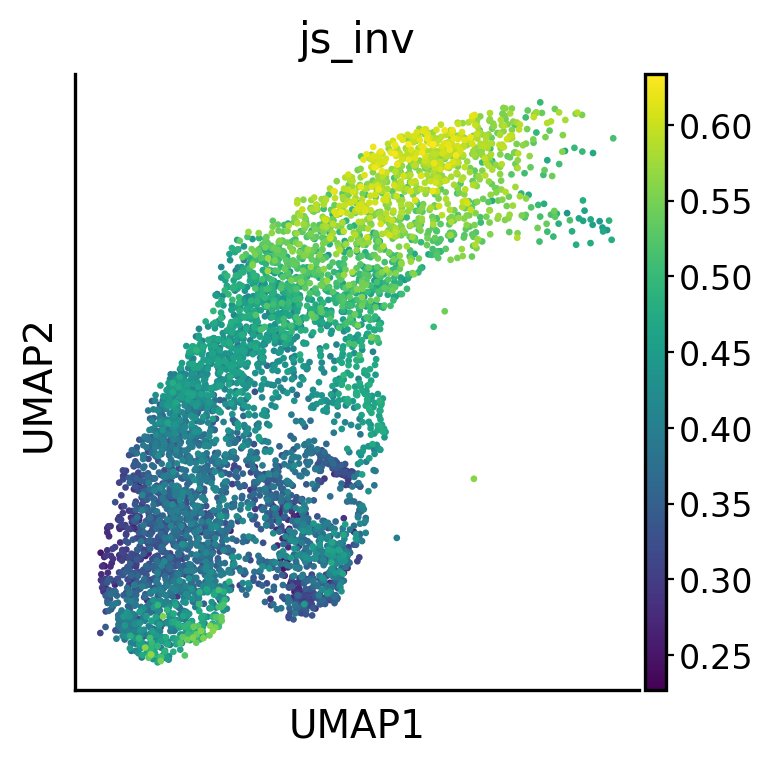

In [35]:
sc.pl.umap(adata_15, color="js_inv")

In [36]:
adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")

/tmp/ipykernel_1105607/2605882233.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")


,js_inv
cell_type_refined,
Delta,0.341386
Fev+ Beta,0.353904
Alpha,0.358385
Fev+ Alpha,0.358936
Beta,0.396418
Fev+,0.401300
Epsilon,0.420212
"Fev+ Delta,1",0.452304
"Fev+ Delta,0",0.458725
